In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [171]:
filename = '/content/drive/MyDrive/DSDojo/Colab Notebooks/Coding Dojo/Project 2/Project 2 cleaned final.csv'
df = pd.read_csv(filename, index_col='ID')
df.rename(columns={'Other':'Other_Rel_ID','Other.1':'Other'},inplace= True)
df.head()

,Still_Open,Art_Film_Music_1,Broadcasting_TV_2,Camps_Retrest_Confrc_3,Child_Adopt_Orphan_4,Chuch_Plant_5,Consult_Org&Tech_Support_6,Counceling_Rehab_7,Relig_Reform_Revival_8,Econom_Develop_9,Fellowship_Prof_Assoc_10,Health_Med_Serc_11,Housing_Cloth_Food_12,Interfaith_Dialog_13,Leader_Train_Edu_14,Legal_Political_Advocacy_15,Missions_16,Preach_Speak_Lect_17,Publishing_18,Other_19,Q3_ONE,Any_Category_Selec,Christian_NP,Jewish_NP,Muslim_NP,Hindu_NP,Buddhist_NP,IR_NP,Not_Reli_NP,Other_NP,Missing_Reli_Id_NP,Identifies_w_Denomination,Denom_Bible_Believ,Denom_Charismatic,Denom_Ecumenical,Denom_Evangelical,Denom_Fundamental,Denom_Mainline,Denom_Pentecostal,Denom_Theo_Conserv,...,Evangelical,Fundamentalist,Mainline,Pentecostal,Seeker,Theologically_Conservative,Theologically_Liberal,Other_Rel_ID,Att_Relig_Serc,Wtinessed_Healing,Felt_Called,Had_Vision,Heard_Voice_God,Had_Dream,Had_Relig_Conv_Exper,Changed_Profoundly_Due_Relig_Exper,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Main_Category,Refused_Budget_Perc,Num_Budget_Spons,Perc_Finc_Indiv_Gifts_Don,Perc_Sales_Goods,Perc_Memberships,Perc_Spec_Fundraise,Perc_Grants_Don_Relig_Cong,Perc_Grants_Don_Denom_Off,Perc_Grants_Don_Relig_Found,Perc_Grant_Don_Sec_Found,Perc_Grant_Don_Bus_Corp,Perc_Grant_Gov,Perc_Other,Other
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11028,1.0,0,0,1,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,10.0,6,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,...,1,0,0,0,0,1,0,0,8,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,10,0,4,5.0,1.0,0,30,0,0,2,0,0,0.0,0,0
11051,1.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,16.0,4,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,...,1,1,0,0,0,1,0,0,8,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,16,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0
11055,1.0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,7.0,8,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,9,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,7,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0
11056,1.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,8.0,5,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,8,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0
11068,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,...,1,1,0,0,0,1,0,0,9,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,19,0,3,30.0,0.0,0,70,60,0,0,0,0,0.0,0,0


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 919 entries, 11028 to 33188
Columns: 313 entries, Still_Open to Other
dtypes: float64(11), int64(300), object(2)
memory usage: 2.2+ MB


In [173]:
df.dtypes


Still_Open                  float64
Art_Film_Music_1              int64
Broadcasting_TV_2             int64
Camps_Retrest_Confrc_3        int64
Child_Adopt_Orphan_4          int64
                             ...   
Perc_Grant_Don_Sec_Found      int64
Perc_Grant_Don_Bus_Corp       int64
Perc_Grant_Gov              float64
Perc_Other                    int64
Other                         int64
Length: 313, dtype: object

We have some values in the target column that are blank. We are going to remove these and make them a 'fake' testing set. Then we will drop these from the original dataset

In [174]:
dfTestLater = df[df['Still_Open'].isnull()]


In [175]:
df = df[df['Still_Open'].notna()]


# Cleaning the Data

Check for duplicates

In [176]:
df.duplicated().value_counts()

False    901
dtype: int64

Drop Unnecessary columns:

In [177]:
dfNP =  df.drop(columns=['Q3_ONE','Any_Category_Selec','Q9_YES','Tot_Budget_Perc','Perc_Other_1','Other_1','Perc_Grants_Don_Relig_Cong1','Perc_Finc_Indiv_Gifts_Don1','Perc_Sales_Goods1','Perc_Memberships1','Perc_Spec_Fundraise1',
                         'Perc_Grants_Don_Denom_Off1','Perc_Grants_Don_Relig_Found1','Perc_Grant_Don_Sec_Found1','Perc_Grant_Don_Bus_Corp1','Perc_Grant_Gov1'])

In [178]:
dfNP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 11028 to 33188
Columns: 297 entries, Still_Open to Other
dtypes: float64(7), int64(289), object(1)
memory usage: 2.0+ MB


For Q24_1 (How many founders would you say this nonprofit had?) and Q24_2 (How many of these founders are still involved with this nonprofit?) we are going to replace the null values with the mode. This should not greatly effect the results as most NPs had between 1-3 founders so it makes sense to replace with the most common value instead of a 0 or an average.

In [179]:
dfNP['Num_Founders'].value_counts(dropna=False)

2.0      240
1.0      220
3.0      120
4.0       75
5.0       60
6.0       42
10.0      33
8.0       22
NaN       19
7.0       19
15.0      10
12.0       9
20.0       8
9.0        6
11.0       4
16.0       3
0.0        2
25.0       2
200.0      1
21.0       1
50.0       1
41.0       1
30.0       1
19.0       1
13.0       1
Name: Num_Founders, dtype: int64

In [180]:
numfound = dfNP['Num_Founders'].mode()[0]
numfoundinv = dfNP['Num_Founders_Still_Inv'].mode()[0]
dfNP['Num_Founders'] = dfNP['Num_Founders'].replace(np.nan,numfound)

In [181]:
dfNP['Num_Founders_Still_Inv'] = dfNP['Num_Founders_Still_Inv'].replace(np.nan,numfoundinv)

In [182]:
dfNP['Num_Founders_Still_Inv'].value_counts(dropna=False)

1.0      293
2.0      263
3.0      105
0.0       52
4.0       52
5.0       45
6.0       31
7.0       15
8.0       15
10.0      11
12.0       6
9.0        4
25.0       2
15.0       2
20.0       1
200.0      1
36.0       1
16.0       1
120.0      1
Name: Num_Founders_Still_Inv, dtype: int64

Check for inconistent datatypes

In [183]:
dfNP.select_dtypes(exclude='int')

,Still_Open,Num_Founders,Num_Founders_Still_Inv,Yrs_Of_Training,Num_Hrs_PM_At_NP,Perc_Finc_Indiv_Gifts_Don,Perc_Sales_Goods,Perc_Grant_Gov
ID,,,,,,,,
11028,1.0,1.0,1.0,12,200.0,5.0,1.0,0.0
11051,1.0,15.0,3.0,4,20.0,100.0,0.0,0.0
11055,1.0,1.0,1.0,2,30.0,100.0,0.0,0.0
11056,1.0,4.0,2.0,0,4.0,100.0,0.0,0.0
11068,1.0,4.0,0.0,0,100.0,30.0,0.0,0.0
...,...,...,...,...,...,...,...,...
33172,1.0,7.0,0.0,0,12.0,40.0,15.0,0.0
33176,1.0,3.0,1.0,0,50.0,75.0,10.0,0.0
33179,1.0,3.0,1.0,0,160.0,50.0,10.0,0.0


Lets convert these to ints or floats where applicable


In [184]:
dfNP['Still_Open'] = dfNP['Still_Open'].astype(int)
dfNP['Num_Founders'] = dfNP['Num_Founders'].astype(int)
dfNP['Num_Founders_Still_Inv'] = dfNP['Num_Founders_Still_Inv'].astype(int)


In [185]:
dfNP['Yrs_Of_Training'].sort_values()

ID
32741    "1 year in youth ministry, 3 years in Music Ed...
12760                         "4 Undergrad, 4 at Seminary"
32328                         "8, 2 to 3 classes per year"
31552                   "Just started, less than one year"
31022                         "THM 4 years, D Min 4 years"
                               ...                        
13722                                             On going
32900                                        Over 40 years
21199                                    Part time student
32801    Was in the middle of my first year which is st...
32812                                                 many
Name: Yrs_Of_Training, Length: 901, dtype: object

In [186]:
#manually convert items that will cause an issue with the code that will follow in the second cell. Also give all ambiguous records like "many" a value of 99 which will later be replaced with 
# the Average

In [187]:
dfNP['Yrs_Of_Training'] = dfNP['Yrs_Of_Training'].replace(['3 1/2','3.5','4 yrs','4 years',
                                                           '"1 year in youth ministry, 3 years in Music Education"'],
                                                          '4').replace(['"4 Undergrad, 4 at Seminary"','"THM 4 years, D Min 4 years"','"8, 2 to 3 classes per year"','B'],
                                                                       '8').replace(['Was in the middle of my first year which is still continuing','I','Part time student',
                                                                                     '"Just started, less than one year"'],'1').replace('9 years 10 months','10').replace(
                                                                                         '"They would say a lifetime, but technically 8 beyond undergrad"','12'
                                                                                     ).replace(['many','Lifetime','On going'],'99')

Remove all text and leave only numbers

In [188]:
dfNP['Yrs_Of_Training'] = dfNP['Yrs_Of_Training'].str.extract('(\d+)',expand = False)

Now we replace 99 with the average of the values where the values are not 99 or 0

In [189]:
avgtraining = round(dfNP[(dfNP['Yrs_Of_Training']!='99') & (dfNP['Yrs_Of_Training']!='0')]['Yrs_Of_Training'].astype(int).mean())
dfNP['Yrs_Of_Training'] = dfNP['Yrs_Of_Training'].astype(int).replace('99',avgtraining)
dfNP['Yrs_Of_Training'].value_counts(dropna=False)

0     474
4      89
3      73
2      71
1      33
6      29
5      27
8      26
10     15
12     10
7      10
30      6
9       5
15      5
14      3
20      3
25      3
99      3
11      2
35      2
40      2
50      2
16      1
54      1
18      1
22      1
23      1
27      1
31      1
41      1
Name: Yrs_Of_Training, dtype: int64

In [190]:
dfNP.select_dtypes(exclude=['int','float'])
#All values are in the correct datatype format now

""
ID
11028
11051
11055
11056
11068
...
33172
33176
33179


Encode the only non-encoded column

In [191]:

dfNP = pd.get_dummies(dfNP, columns=['Main_Category'], drop_first= True)
dfNP

,Still_Open,Art_Film_Music_1,Broadcasting_TV_2,Camps_Retrest_Confrc_3,Child_Adopt_Orphan_4,Chuch_Plant_5,Consult_Org&Tech_Support_6,Counceling_Rehab_7,Relig_Reform_Revival_8,Econom_Develop_9,Fellowship_Prof_Assoc_10,Health_Med_Serc_11,Housing_Cloth_Food_12,Interfaith_Dialog_13,Leader_Train_Edu_14,Legal_Political_Advocacy_15,Missions_16,Preach_Speak_Lect_17,Publishing_18,Other_19,Christian_NP,Jewish_NP,Muslim_NP,Hindu_NP,Buddhist_NP,IR_NP,Not_Reli_NP,Other_NP,Missing_Reli_Id_NP,Identifies_w_Denomination,Denom_Bible_Believ,Denom_Charismatic,Denom_Ecumenical,Denom_Evangelical,Denom_Fundamental,Denom_Mainline,Denom_Pentecostal,Denom_Theo_Conserv,Theo_liberal,Denom_Inter_Denom,...,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Refused_Budget_Perc,Num_Budget_Spons,Perc_Finc_Indiv_Gifts_Don,Perc_Sales_Goods,Perc_Memberships,Perc_Spec_Fundraise,Perc_Grants_Don_Relig_Cong,Perc_Grants_Don_Denom_Off,Perc_Grants_Don_Relig_Found,Perc_Grant_Don_Sec_Found,Perc_Grant_Don_Bus_Corp,Perc_Grant_Gov,Perc_Other,Other,Main_Category_2,Main_Category_3,Main_Category_4,Main_Category_5,Main_Category_6,Main_Category_7,Main_Category_8,Main_Category_9,Main_Category_10,Main_Category_11,Main_Category_12,Main_Category_13,Main_Category_14,Main_Category_15,Main_Category_16,Main_Category_17,Main_Category_18,Main_Category_19,Main_Category_20
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11028,1,0,0,1,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,4,5.0,1.0,0,30,0,0,2,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11051,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
11055,1,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
11056,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,100.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11068,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,3,30.0,0.0,0,70,60,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33172,1,0,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,4,40.0,15.0,0,40,0,0,0,0,5,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
33176,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,3,75.0,10.0,15,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
33179,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,4,50.0,10.0,30,0,10,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [192]:
#Lastly double check there are no Nulls left
dfNP.isnull().sum().sum()


52

In [193]:
null_columns=dfNP.columns[dfNP.isnull().any()]

In [194]:
null_columns

Index(['Num_Hrs_PM_At_NP'], dtype='object')

In [195]:
#replace nulls in 'Num_Hrs_PM_At_NP' with the average
avghrsmonth = round(dfNP['Num_Hrs_PM_At_NP'].mean())
dfNP['Num_Hrs_PM_At_NP'].fillna(avghrsmonth,inplace = True)

In [196]:
null_columns=dfNP.columns[dfNP.isnull().any()]
null_columns

Index([], dtype='object')

# EDA - Visualizations

These will be done exclusively in Power BI and will not be included here. Please see .Pbix file in Github Repo, as well as some images of the visuals included in the .README

# Modeling

**Baseline Model**

In [197]:
BaseAcc = dfNP['Still_Open'].sum()/dfNP['Still_Open'].count()
BaseAcc
#Must beat 0.959 Accuracy to have a worthwhile model - rough. haha

0.9589345172031076


**Train Test Split, Followed by over-sampling to counter an unbalanced target vector**

In [198]:
y = dfNP['Still_Open'].values
X = dfNP.drop(columns='Still_Open')


In [199]:
#TTS
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 3,stratify = y)

In [200]:
#OverSample
oversample = SMOTE()
Xo, yo = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [201]:
Xo.shape

(1294, 314)

In [202]:
yo.shape

(1294,)

In [203]:
#scale
scaler = StandardScaler()
scaler.fit(Xo)
Xo = scaler.transform(Xo)
X_test = scaler.transform(X_test)

**Pick PCA Components**

In [204]:
pca = PCA()
pca.fit(Xo)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Proportion of Explained Variance')

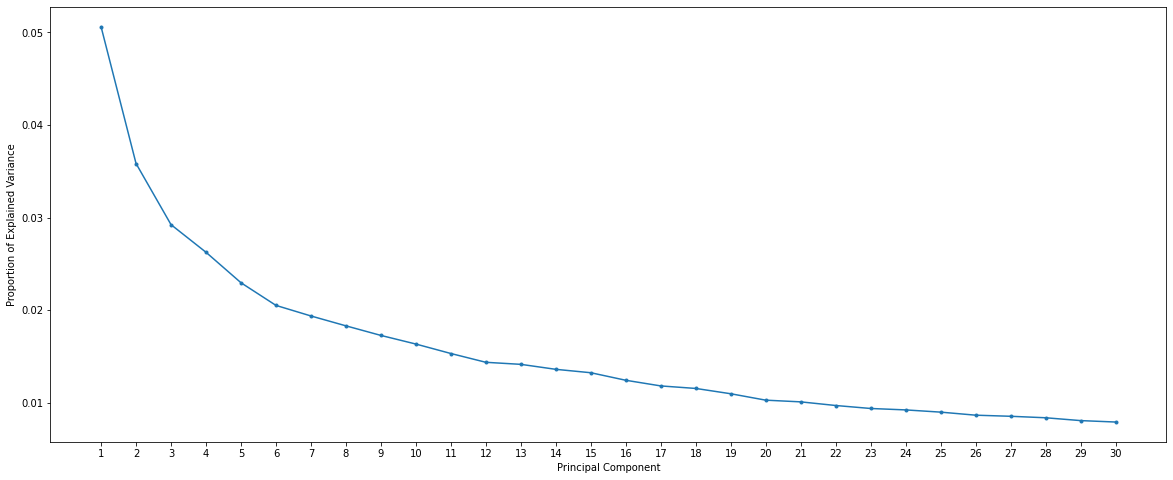

In [205]:
#plot first 30 vars only
plt.figure(figsize=(20,8))
plt.plot(range(1, 31), pca.explained_variance_ratio_[:30], marker = '.')
plt.xticks(ticks = range(1, 31))
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')

In [206]:
# how many PCs do we need to explain at lease 95% of the variance
totvar = 0
numPC = 0
i= 0
while totvar <.95:
  totvar += pca.explained_variance_ratio_[i]
  i += 1
  numPC += 1
numPC

189

In [169]:
Xo.shape

(1294, 314)

In [207]:
pca = PCA(.95)
Xopca = pca.fit_transform(Xo)
XopcaTest = pca.transform(X_test)

In [208]:
Xopca.shape

(1294, 189)

In [165]:
yo.shape

(1294,)

Therefore, we need 190 PCs to explain at least 95% of the variance

In [166]:
# pca = PCA(.95)
# knn = KNeighborsClassifier()
# rf = RandomForestClassifier(random_state = 3)
# lr = LogisticRegression(random_state = 3)
# xgb = XGBClassifier(random_state = 3)
# vc = VotingClassifier(estimators=[('knn',knn),('rf',rf),('lr',lr),('xgb',xgb)])
# pipe = Pipeline(steps=[('pca',pca),('vc',vc)])

**KNN Classification - With PCA and Pipeline**

In [209]:
knn = KNeighborsClassifier()

In [210]:
n = [25,50,100,200]
params = {'n_neighbors':[10,25,50,100]}
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10, random_state= 3)
scoregrid = {'Acc':'accuracy'}
search = GridSearchCV(estimator=knn,param_grid=params,n_jobs=-1, cv=cv)
search.fit(Xopca,yo)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=3),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [10, 25, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [211]:
search.best_params_

{'n_neighbors': 10}

In [212]:
search.best_score_

0.6185459878483134

In [220]:
#Final KNN Model:
print('KNN (n=10) Training Accuracy:', accuracy_score(yo, search.predict(Xopca)))
print('KNN (n=10) Testing Accuracy:', accuracy_score(y_test, search.predict(XopcaTest)))

KNN (n=10) Training Accuracy: 0.6692426584234931
KNN (n=10) Testing Accuracy: 0.3672566371681416


**Random Forest - Wih PCA and Pipeline**

In [213]:
rf = RandomForestClassifier(random_state = 3)

In [216]:
n = [25,50,100,200]
#c = [0.001,0.01,0.1,1]
params = {'n_estimators': n, 'max_depth':[None, 3,  5, 10]}
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10, random_state= 3)
scoregrid = {'Acc':'accuracy'}

In [217]:
rfsearch = GridSearchCV(estimator=rf,param_grid=params,n_jobs=-1, cv=cv)
rfsearch.fit(Xopca,yo)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=3),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                     

In [221]:
rfsearch.best_params_

{'max_depth': None, 'n_estimators': 50}

In [223]:
rfsearch.best_score_

1.0

In [224]:
print('RF (n_estimators: 50, Max_depth: None) Training Accuracy:', accuracy_score(yo, rfsearch.predict(Xopca)))
print('RF (n_estimators: 50, Max_depth: None) Testing Accuracy:', accuracy_score(y_test, rfsearch.predict(XopcaTest)))

RF (n_estimators: 50) Training Accuracy: 1.0
RF (n_estimators: 50) Testing Accuracy: 0.9601769911504425


**Logistic Regression - With PCA and Pipeline**

In [225]:
 lr = LogisticRegression(random_state = 3)

In [237]:
#n = [25,50,100,200]
c = [0.001,0.01,0.1,1]
params = {'C':c,'penalty':['l1','l2']}
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10, random_state= 3)
scoregrid = {'Acc':'accuracy'}
lrsearch = GridSearchCV(estimator=lr,param_grid=params,n_jobs=-1, cv=cv)
lrsearch.fit(Xopca,yo)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=3),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=3, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [238]:
lrsearch.best_params_

{'C': 1, 'penalty': 'l2'}

In [241]:
lrsearch.best_score_

0.9809125737032715

In [240]:
print('lr (C: 1,  penalty: l2) Training Accuracy:', accuracy_score(yo, lrsearch.predict(Xopca)))
print('lr (C: 1, penalty: l2) Testing Accuracy:', accuracy_score(y_test, lrsearch.predict(XopcaTest)))

lr (C: 1,  penalty: l2) Training Accuracy: 1.0
lr (C: 1, penalty: l2) Testing Accuracy: 0.9292035398230089


XGBoost

In [244]:
xgb = XGBClassifier(random_state = 3)

In [245]:
n = [25,50,100,200]
params = {'n_estimators': n, 'max_depth':[3, 4, 6,8], 'learning_rate':[0.1,0.3,0.5], 'subsample':[1,0.5]}
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10, random_state= 3)
scoregrid = {'Acc':'accuracy'}
xgbsearch = GridSearchCV(estimator=xgb,param_grid=params,n_jobs=-1, cv=cv)
xgbsearch.fit(Xopca,yo)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=3),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=3, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'max_depth': [3, 4

In [246]:
xgbsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}

In [247]:
xgbsearch.best_score_

1.0

In [249]:
print('xgb (learning_rate: 0.1, max_depth: 3, n_estimators: 50, subsample: 1) Training Accuracy:', accuracy_score(yo, xgbsearch.predict(Xopca)))
print('xgb (learning_rate: 0.1, max_depth: 3, n_estimators: 50, subsample: 1) Testing Accuracy:', accuracy_score(y_test, xgbsearch.predict(XopcaTest)))

xgb (learning_rate: 0.1, max_depth: 3, n_estimators: 50, subsample: 1) Training Accuracy: 1.0
xgb (learning_rate: 0.1, max_depth: 3, n_estimators: 50, subsample: 1) Testing Accuracy: 0.9601769911504425


# Code Sources:
[Fill NaN with Mode](https://stackoverflow.com/questions/40619445/how-to-replace-na-values-with-mode-of-a-dataframe-column-in-python/40621330)

[Select all columns of a certain datatype](https://cmdlinetips.com/2019/04/how-to-select-columns-by-data-type-in-pandas/)

[Strip all text from column - Leave numbers](https://stackoverflow.com/questions/44117326/how-can-i-remove-all-non-numeric-characters-from-all-the-values-in-a-particular)

[Show columns with Null values](https://dzone.com/articles/pandas-find-rows-where-columnfield-is-null)

# Acknowledgements 

- Noelle Brown for help through the DS Process
- Original data from : [Survey of Faith Based Nonprofit Organizations  - the ARDA](https://www.thearda.com/Archive/Files/Descriptions/NONPROF11.asp)